In [3]:
import h5py
import time
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from simarUtils import *

In [4]:
# if given quat use Rot.from_quat asmatrix()
R_cam_base = np.array([
    [ 0.144, -0.598, 0.789],
    [-0.978, 0.036, 0.206],
    [-0.152, -0.801, -0.579]
])
Tr_cam_base = np.array([[-0.017, -0.202, 0.491]])
# Tr_cam_base = np.array([[0.012, -0.254, 0.534]]) #measured


T_cam_base = np.concatenate([R_cam_base, Tr_cam_base.T], axis=1)
T_cam_base = np.concatenate([T_cam_base, np.array([[0, 0, 0, 1]])], axis=0)
print("Full Transform: ", T_cam_base)
# T_cam_base = np.linalg.inv(T_cam_base)

#Our calibrated intrinsics
# intrinsics = np.array([
#     [625.579822, 0.000000, 302.919366, 0.000000],
#     [0.000000, 624.831489, 248.344753, 0.000000],
#     [0.000000, 0.000000, 1.000000, 0.000000]
# ])

#Internal realsense numbers
intrinsics = np.array([
    [616.0, 0.0, 313.4, 0.0],
    [0.0, 615.7, 236.7, 0.0],
    [0.0, 0.0, 1.0, 0.0]
])


Full Transform:  [[ 0.144 -0.598  0.789 -0.017]
 [-0.978  0.036  0.206 -0.202]
 [-0.152 -0.801 -0.579  0.491]
 [ 0.     0.     0.     1.   ]]


## Hand Data

In [6]:
h5py_file = h5py.File("/coc/flash7/datasets/v1_datasetMimicplay.hdf5", "r")
nested_ds_print(h5py_file)

dict with keys:  <KeysViewHDF5 ['data', 'mask']>
data: dict with keys:  <KeysViewHDF5 ['demo_0', 'demo_1', 'demo_11', 'demo_12', 'demo_13', 'demo_14', 'demo_15', 'demo_16', 'demo_17', 'demo_2', 'demo_3', 'demo_4', 'demo_5', 'demo_6', 'demo_7', 'demo_8', 'demo_9']>
	demo_0: dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
		actions: (1181, 30)
		obs: dict with keys:  <KeysViewHDF5 ['Gripper_position', 'ee_pose', 'ee_pose_full_unnorm', 'ee_pose_unnorm', 'front_image_1', 'front_image_2', 'wrist_cam_1']>
			Gripper_position: ()
			ee_pose: (1181, 3)
			ee_pose_full_unnorm: (1181, 7)
			ee_pose_unnorm: (1181, 3)
			front_image_1: (1181, 480, 640, 3)
			front_image_2: (1, 1920, 1080, 3)
			wrist_cam_1: (1, 640, 480, 3)
	demo_1: dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
		actions: (1175, 30)
		obs: dict with keys:  <KeysViewHDF5 ['Gripper_position', 'ee_pose', 'ee_pose_full_unnorm', 'ee_pose_unnorm', 'front_image_1', 'front_image_2', 'wrist_cam_1']>
			Gripper_position: ()
			ee_po

In [7]:
def scatter_3d(points, angle=0):
    """
        make a 3d scatter plot for points of shape (Time, 3) where 3 is x,y,z
        color the points by time, make the axis interactive
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:,0], points[:,1], points[:,2], c=range(points.shape[0]))
    #rotate the 3d plot
    ax.view_init(15, angle)
    # plt.show()


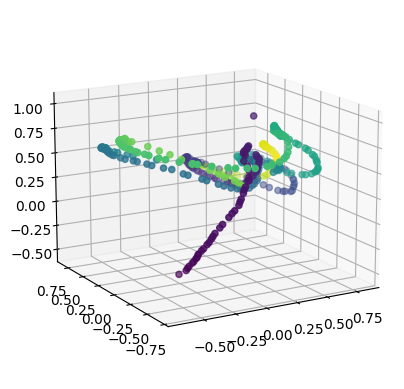

In [8]:
h5py_file["data/demo_0/obs/ee_pose"].shape
scatter_3d(h5py_file["data/demo_0/obs/ee_pose"][0:500, :3], -120)

In [9]:
h5py_file["data/demo_0/obs/ee_pose"][100:110][:]

array([[0.25087689, 0.63876992, 0.3117824 ],
       [0.24759885, 0.64367258, 0.31197703],
       [0.23768477, 0.65044251, 0.31343881],
       [0.23626664, 0.65154879, 0.31593795],
       [0.23513838, 0.65129797, 0.31912014],
       [0.23558765, 0.64312435, 0.32449542],
       [0.23891805, 0.63444794, 0.32655544],
       [0.25876513, 0.58324082, 0.32659283],
       [0.27036041, 0.54111614, 0.31844871],
       [0.32412908, 0.42706176, 0.29315451]])

In [10]:
h5py_file["data/demo_0/actions"][100][:]

array([ 0.59811054,  0.03543127,  0.14237831,  0.77236677,  0.44158757,
        0.2631618 ,  0.68736354,  0.57589399,  0.2780353 ,  0.69624505,
        0.56116187,  0.28456462,  0.1453656 , -0.25412078,  0.32879276,
       -0.58054082,  0.07200848,  0.63641445, -0.6727051 ,  0.39087192,
        0.68561201, -0.6352771 ,  0.38843134,  0.67597828,  0.59799207,
        0.05013302,  0.39880089,  0.61521896,  0.56401076,  0.35426388])

In [11]:
def project_3d_to_2d(x, y, z):
    # focal_length_x, focal_length_y, principal_point_x, principal_point_y
    camera_intrinsics = (616.16, 615.714, 313.42, 236.67)
    focal_length_x, focal_length_y, principal_point_x, principal_point_y = camera_intrinsics

    # Apply camera intrinsics to project 3D point to 2D
    u = (focal_length_x * x / z) + principal_point_x
    v = (focal_length_y * y / z) + principal_point_y

    return u, v

[ 17.771406 122.093536 427.196381]
Pixel value (339.0523087178962, 412.642229092231)


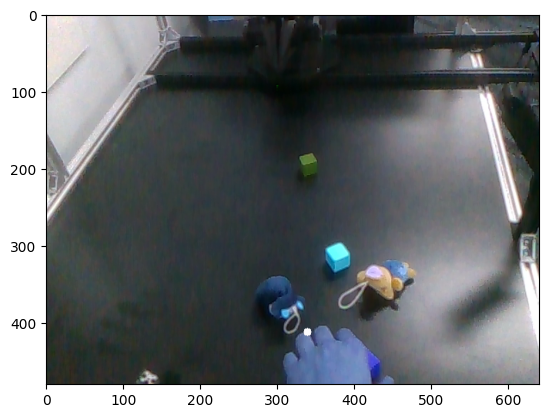

In [17]:
T = 100
hand_loc = h5py_file["data/demo_0/obs/ee_pose_unnorm"][T][0:3]
print(hand_loc)
px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
# px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
print("Pixel value", px_val)
frame = draw_dot_on_frame(h5py_file["data/demo_0/obs/front_image_1"][T], px_val, show=True)


In [18]:
# Robot frame is x (forward pos), y(left pos), z (up pos)

video = torch.zeros(h5py_file["data/demo_0/obs/front_image_1"][:400].shape)
for t in range(400):
    # hand_loc = h5py_file["demo_0/obs/ee_pose"][t][0, 0:3]
    hand_loc = h5py_file["data/demo_0/obs/ee_pose_unnorm"][t][0:3]
    # print(hand_loc)
    # px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
    px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
    # print("Pixel value", px_val)
    frame = draw_dot_on_frame(h5py_file["data/demo_0/obs/front_image_1"][t], px_val, show=False)
    video[t] = torch.from_numpy(frame)
torchvision.io.write_video("hand_traj.mp4", video, fps=30)

[-91.167618  13.367264 155.983826]
Pixel value (-46.706052472132626, 289.4345192296796)
[-87.11898    1.692047 175.914917]
Pixel value (8.276856756496727, 242.59227790755233)
[-85.787354   0.189011 184.086578]
Pixel value (26.279369678543333, 237.3021847041667)
[-84.575462  -1.690506 191.314972]
Pixel value (41.0314037435607, 231.22940013265662)
[-81.763176  -5.38826  203.658661]
Pixel value (66.04923620930614, 220.37986482308256)
[-80.613861  -7.417694 209.589645]
Pixel value (76.42815532294071, 214.87895186154827)
[-79.805145 -11.247711 221.592468]
Pixel value (91.51381976286308, 205.41725394252114)
[-79.678963 -13.758972 227.136108]
Pixel value (97.27211283940821, 199.37257617512753)
[-80.461876 -16.74884  237.264114]
Pixel value (104.46556234677783, 193.20579844881217)
[-80.905907 -19.650848 243.702789]
Pixel value (108.8635242137504, 187.02222093633077)
[-81.139793 -26.493973 259.204468]
Pixel value (120.54101438436629, 173.73624651345898)
[-80.874207 -30.725555 268.136658]
Pixel 

In [11]:
video.shape

torch.Size([400, 480, 640, 3])

In [14]:
video.shape

torch.Size([400, 480, 640, 3])

## Robot Data

## Calibration Data

In [19]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as Rot

In [20]:
calib = h5py.File("/coc/flash7/skareer6/calibrate_samples/robomimic.hdf5", "r+")
demo = calib["demo1"]

In [21]:
nested_ds_print(calib)

dict with keys:  <KeysViewHDF5 ['demo0', 'demo1']>
demo0: dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
	actions: dict with keys:  <KeysViewHDF5 ['ee_pose']>
		ee_pose: (700, 7)
	obs: dict with keys:  <KeysViewHDF5 ['ee_pose', 'front_img_1', 'front_img_2', 'gripper_position', 'joint_positions', 'joint_vel', 'wrist_img_1']>
		ee_pose: (700, 7)
		front_img_1: (700, 480, 640, 3)
		front_img_2: (700, 480, 640, 3)
		gripper_position: (700,)
		joint_positions: (700, 6)
		joint_vel: (700, 6)
		wrist_img_1: (700, 480, 640, 3)
demo1: dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
	actions: dict with keys:  <KeysViewHDF5 ['ee_pose']>
		ee_pose: (700, 7)
	obs: dict with keys:  <KeysViewHDF5 ['ee_pose', 'front_img_1', 'front_img_2', 'gripper_position', 'joint_positions', 'joint_vel', 'wrist_img_1']>
		ee_pose: (700, 7)
		front_img_1: (700, 480, 640, 3)
		front_img_2: (700, 480, 640, 3)
		gripper_position: (700,)
		joint_positions: (700, 6)
		joint_vel: (700, 6)
		wrist_img_1: (700, 480, 6

[-0.05215535 -0.9510681   1.2409905   0.04755341 -0.22242722 -0.08436894]
<KeysViewHDF5 ['ee_pose', 'front_img_1', 'front_img_2', 'gripper_position', 'joint_positions', 'joint_vel', 'wrist_img_1']>


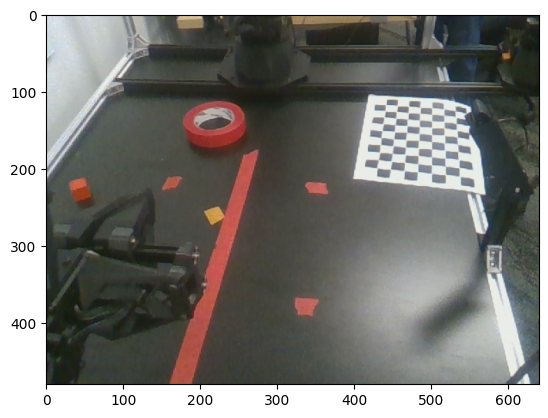

In [26]:
t=100
# Robot frame is x (forward pos), y(left pos), z (up pos)
# print(demo["obs/front_img_1"][t].shape)
print(demo["obs/joint_positions"][t])
print(demo["obs"].keys())

plt.imshow(demo["obs/front_img_1"][t])

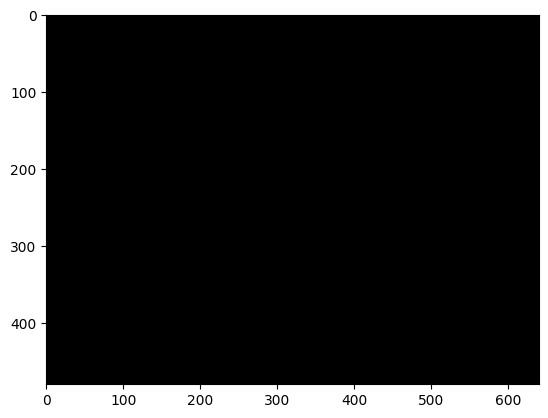

In [27]:
plt.imshow(demo["obs/front_img_2"][t])

3d pos in base frame:  [ 0.35833236 -0.17932137  0.18936851  1.        ]
3d pos in cam frame:  [0.07760897 0.01822989 0.47535887 1.        ]
2d pos cam frame:  [413.97059348 260.31194073   1.        ]
[413.97059348 260.31194073   1.        ]


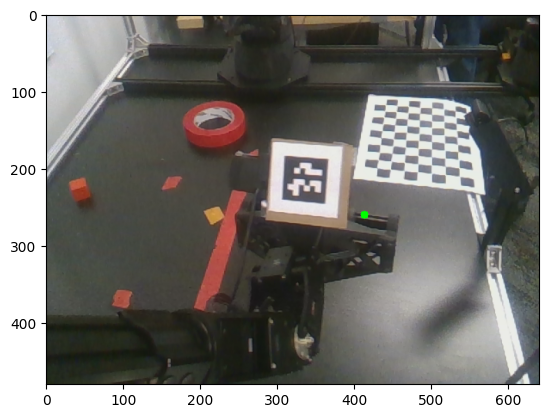

In [15]:
T = 200
px_val = ee_pose_to_cam_pixels(demo["obs/ee_pose"][T][:3], T_cam_base, intrinsics)
print(px_val)
draw_dot_on_frame(demo["obs/front_img_1"][T], px_val)

3d pos in base frame:  [ 0.37 -0.14 -0.02  1.  ]
3d pos in cam frame:  [0.07256679 0.18038024 0.61396421 1.        ]
2d pos cam frame:  [386.20740315 417.59020348   1.        ]
[386.20740315 417.59020348   1.        ]


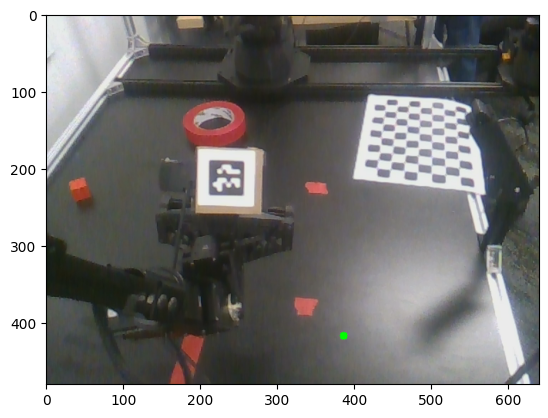

In [18]:
T = 500
px_val = ee_pose_to_cam_pixels(np.array([0.37, -0.14, -0.02]), T_cam_base, intrinsics)
print(px_val)
draw_dot_on_frame(demo["obs/front_img_1"][T], px_val)

# IK ground up

In [1]:
import h5py
import matplotlib.pyplot as plt

In [2]:
file = h5py.File("/coc/flash7/skareer6/episode_0.hdf5", "r+")
file["observations/qpos"].shape
joint_poses = file["observations/qpos"][0:700]

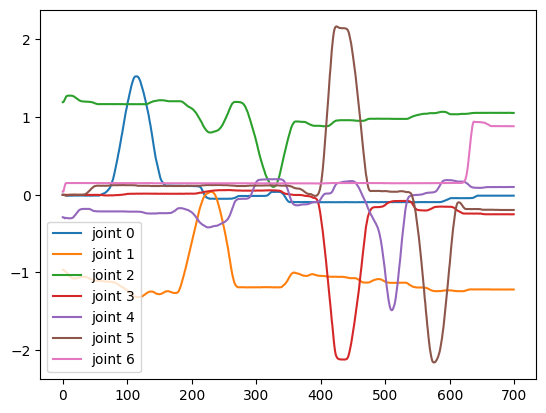

In [5]:
# plt.plot(joint_poses)
#plot each joint in joint_poses and label it in the legend
joint_poses = joint_poses[:, 0:7]
for i in range(joint_poses.shape[1]):
    plt.plot(joint_poses[:,i], label="joint {}".format(i))
plt.legend()
plt.show()

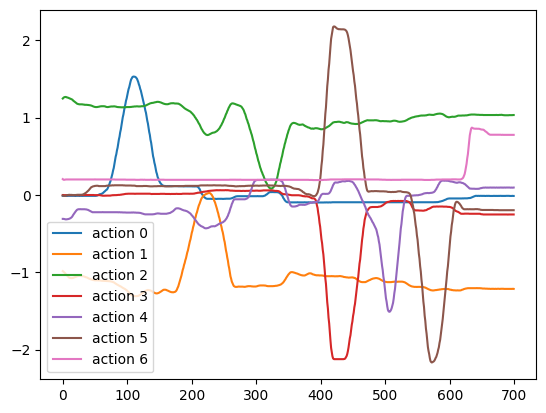

In [6]:
# plot same for actions
actions = file["action"][:, :7]
for i in range(actions.shape[1]):
    plt.plot(actions[:,i], label="action {}".format(i))
plt.legend()
plt.show()

## Next check the poses for 2 known positions

In [28]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from modern_robotics import FKinSpace

In [29]:
file = h5py.File("/coc/flash7/skareer6/touch_points.hdf5", "r+")

In [30]:
M = np.array([[1.0, 0.0, 0.0, 0.536494],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.42705],
    [0.0, 0.0, 0.0, 1.0]])

Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T

In [31]:
joint_poses = file["observations/qpos"][0:700]

[[ 0.72 -0.12  0.69  0.34]
 [ 0.13  0.99  0.04  0.09]
 [-0.68  0.06  0.73  0.03]
 [ 0.    0.    0.    1.  ]]


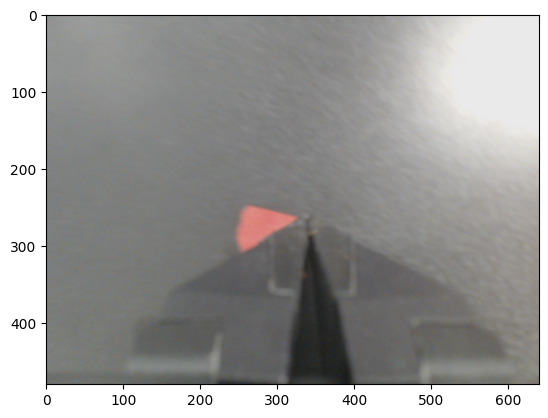

In [54]:
T = 200
# print joint pos and show camera image
joint_poses = joint_poses[:, 0:7]
# print(joint_poses[T])
plt.imshow(file["observations/images/cam_left_wrist"][T])
trans = FKinSpace(M, Slist, joint_poses[T][:6])
print(trans.round(2))